## Introduction to ICESat-2 Surface Velocity Calculations

This notebook is meant to introduce the processing flow for a simple along-track velocity calculation using repeat cysles of ICESat-2 elevation profiles. The notebook covers:
1. Loading elevation data from an hdf5 file using the built-in reader function.
2. Smoothing and differentiating the elevation profile.
3. Correlating the differentiated profile to calculate surface velocities.

In [3]:
# Import the basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
# As an example, import a function from the ICESat-2 surface velocity library
from IS2_velocity.correlation_processing import velocity
help(velocity)

Help on function velocity in module IS2_velocity.correlation_processing:

velocity(x_in, dh1, dh2, dt, output_xs, search_width=100, segment_length=2000, dx=20, corr_threshold=0.65)
    Calculate along-track velocity by correlating the along-track elevation between repeat acquisitions.
    
    Parameters
    ------
    x_in : array
           along-track distance
    dh1 : array
          surface slope at cycle 1
    dh2 : array
          surface slope at cycle 2
    dt : float
         time difference between cycles
    output_xs : array
                along-track distances at which the velocities will be calculated and output
    search_width : float
                   the maximum distance which the stencil array will be moved to look for a good correlation
    segment_length : float
                     the length of the array to be correlated
    dx : float
         spacing between points in the x array
    corr_threshold : float
                     minimum correlation to be cons

## Import ATL06 Dictionaries

Two cycles for a repeat over Foundation Ice Stream are saved within the data directory. Here we load and plot them on top of one another.

In [6]:
# Import the reader script
from IS2_velocity.readers import atl06_to_dict

# read in dictionaries from two different cycles
data_dir = '../data/'
fn_1 = 'processed_ATL06_20190822153035_08480411_003_01.h5'
D1=atl06_to_dict(data_dir+fn_1,'/gt2l', index=None, epsg=3031)
fn_2 = 'processed_ATL06_20190523195046_08480311_003_01.h5'
D2=atl06_to_dict(data_dir+fn_2,'/gt2l', index=None, epsg=3031)

<IPython.core.display.Javascript object>


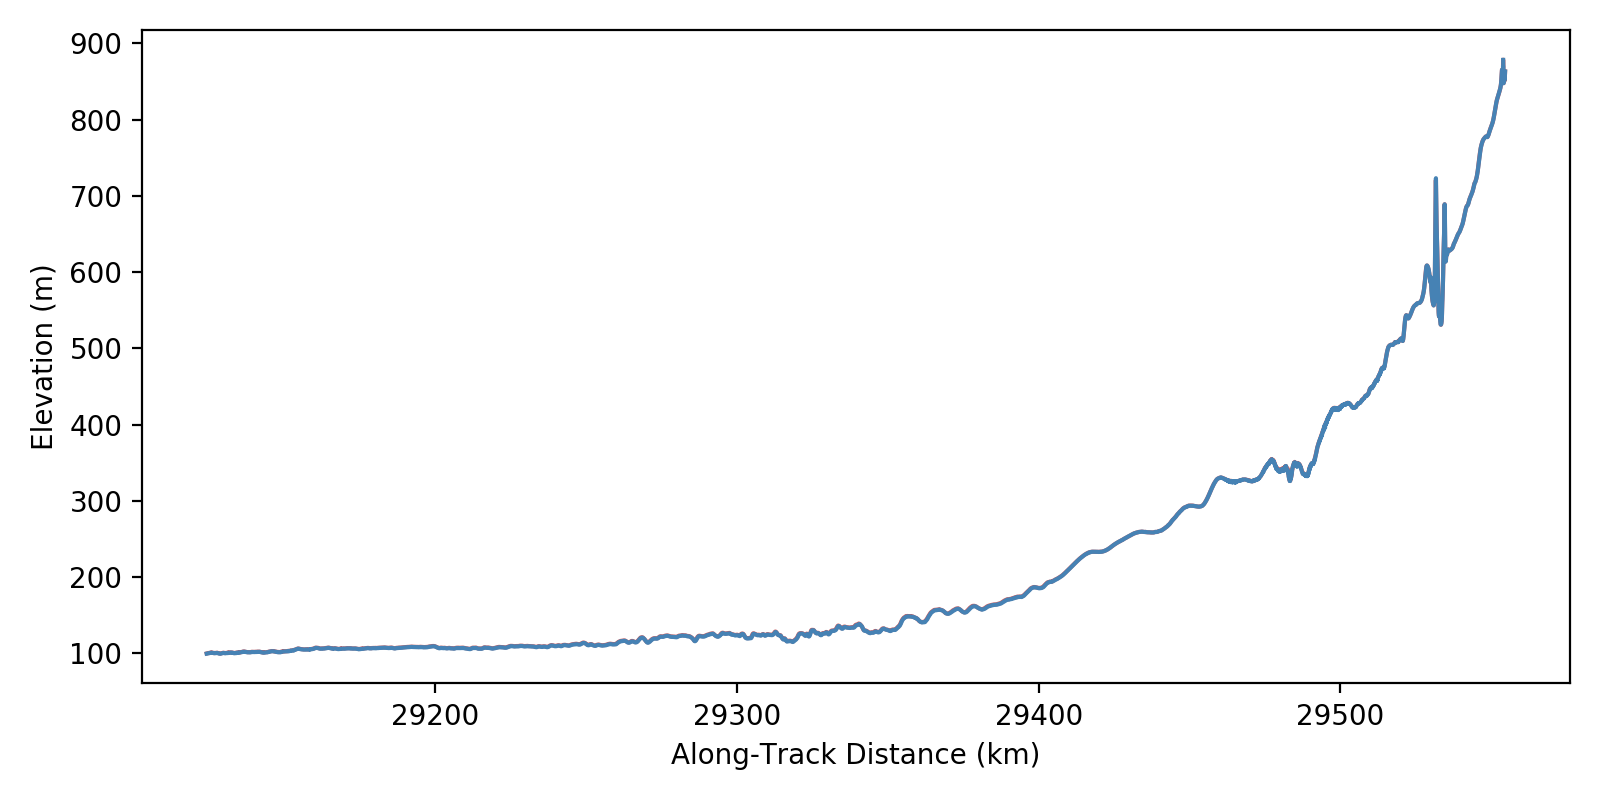

In [7]:
# Plot the landice elevation along the pass.
plt.figure(figsize=(8,4))

plt.plot(D1['x_atc']/1000.,D1['h_li'],c='indianred')
plt.plot(D2['x_atc']/1000.,D2['h_li'],c='steelblue')
plt.ylabel('Elevation (m)')
plt.xlabel('Along-Track Distance (km)')

plt.tight_layout()

## Preprocessing - Smooth and Differentiate

<IPython.core.display.Javascript object>


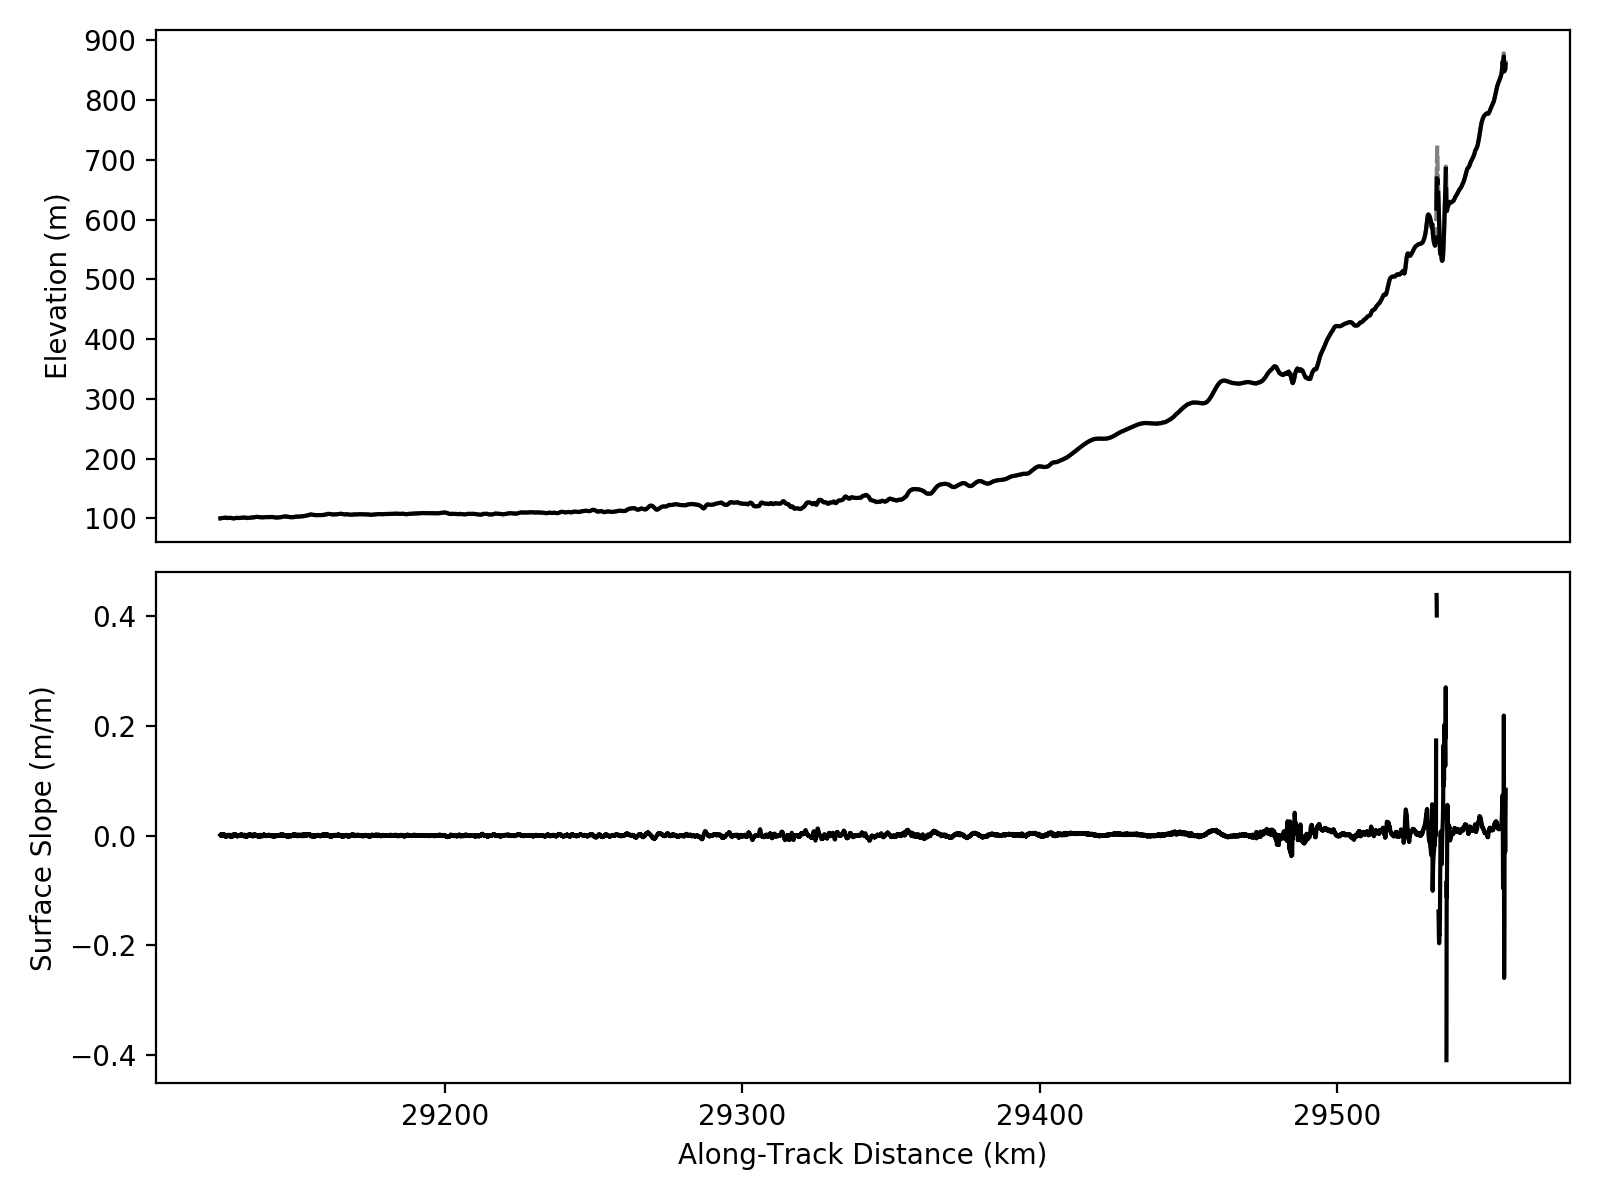

In [9]:
# Import some signal processing functions
from IS2_velocity.correlation_processing import smooth_and_diff, fill_seg_ids

# Get segment ids from the loaded dictionaries
x1,h1 = fill_seg_ids(D1['x_atc'],D1['h_li'],D1['segment_id'])
x2,h2 = fill_seg_ids(D2['x_atc'],D2['h_li'],D2['segment_id'])

# Smooth and differentiate the elevation product (this is a preprocessing step)
h1_smooth,dh1 = smooth_and_diff(x1,h1,win=100)
h2_smooth,dh2 = smooth_and_diff(x2,h2,win=100)

# ------------------------------------------

plt.figure(figsize=(8,6))

# Plot smoothed surface elevation
plt.subplot(211)
plt.tick_params(labelbottom=False,bottom=False)
plt.plot(x1/1000.,h1,c='grey')
plt.plot(x1/1000.,h1_smooth,c='k')
plt.ylabel('Elevation (m)')

# Plot the surface Slope
plt.subplot(212)
plt.plot(x1/1000.,dh1,c='k')
plt.xlabel('Along-Track Distance (km)')
plt.ylabel('Surface Slope (m/m)')

plt.tight_layout()

## Velocity Calculation

More work is yet to be done to select the ideal search_width and segment_Right now, I have:
- search_width=1000
- segment_length=5000
- dx=20
- corr_threshold=.65

<IPython.core.display.Javascript object>


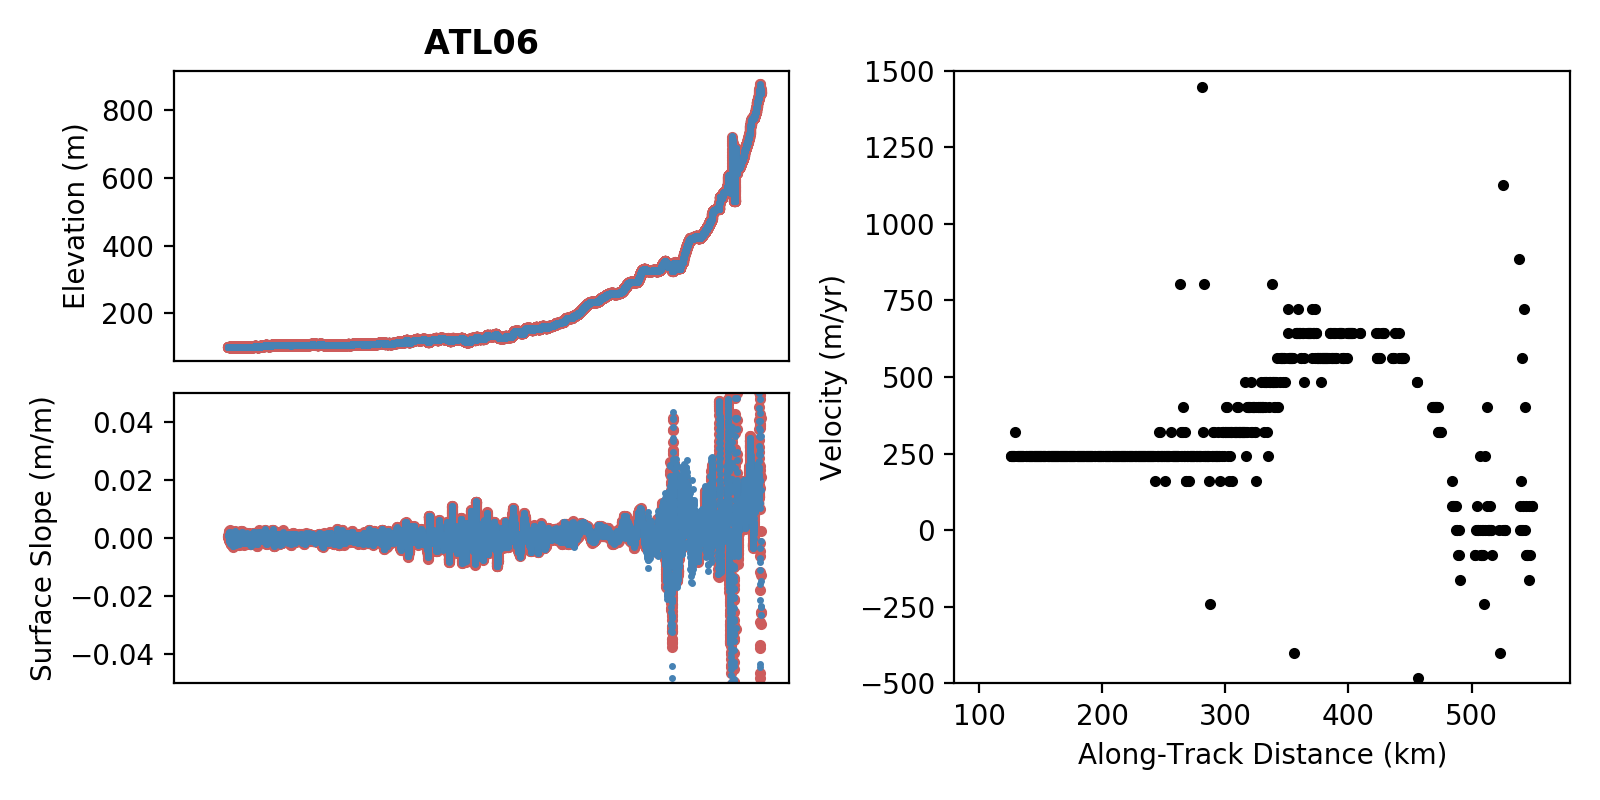

In [10]:
# Import funcitons for the velocity calculation and a time differencing step
from IS2_velocity.correlation_processing import velocity, time_diff

# Calculate time offset
dt = time_diff(D1,D2)
# Where to calculate the velocities
vel_xs = np.linspace(np.min(x1)+1000,np.max(x1)-1000,1000)
# Do the velocity calculation
velocities,correlations = velocity(x1,dh1,dh2,dt,vel_xs,search_width=1000,segment_length=5000)

# ------------------------------------------

from matplotlib.gridspec import GridSpec

plt.figure(figsize=(8,4))
gs = GridSpec(2,2)

# Plot the elevation profiles again
plt.subplot(gs[0,0])
plt.tick_params(bottom=False,labelbottom=False)
plt.plot(x1/1000.-29000,h1,'.',c='indianred')
plt.plot(x2/1000.-29000,h2,'.',c='steelblue',ms=3)
plt.ylabel('Elevation (m)')
plt.title('ATL06',fontweight='bold')
plt.xlim(80,580)

# Plot the slopes again
plt.subplot(gs[1,0])
plt.tick_params(bottom=False,labelbottom=False)
plt.plot(x1/1000.-29000,dh1,'.',c='indianred')
plt.plot(x2/1000.-29000,dh2,'.',c='steelblue',ms=3)
plt.ylim(-.05,.05)
plt.ylabel('Surface Slope (m/m)')
plt.xlim(80,580)

# Plot the calculated velocities along track
ax5 = plt.subplot(gs[:,1])
plt.plot(vel_xs/1000.-29000,velocities,'.',c='k',label='ATL06')
plt.ylabel('Velocity (m/yr)')
plt.xlabel('Along-Track Distance (km)')
plt.xlim(80,580)
plt.ylim(-500,1500)

plt.tight_layout()